# Evaluación de los algoritmos antes y después de aplicar $\chi^2$

## Imports y configuraciones

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder

In [3]:
sys.path.append('../../../lab3/ej7/src') # permite importar modulos de otros directorios

In [4]:
from ds_preprocessing import DataSetPreprocessor
from arff_helper import DataSet
from classifier import KNNClassifier, NBClassifier
from kfold import KFold

## Carga y preprocesamiento de datasets

### Carga y preprocesamiento del dataset original (```ds```) 

In [5]:
ds = DataSet()
ds.load_from_arff('../../../lab2/ej5/datasets/Autism-Adult-Data.arff')
ds.remove_attribute('result')

Sacamos filas sin valor en el atributo ```age``` para que no falle el método ```chi2``` (si hay otros atributos faltantes serán transformados en varios atributos todos con valor ```0``` al invocar ```transform_to_rn```):

In [6]:
indices = ds.pandas_df[ds.pandas_df['age'].isnull()].index
ds.pandas_df = ds.pandas_df.drop(indices)\
    .reset_index()\
    .drop(columns=['index'])

### Transformación a atributos numéricos (```df_numeric```)

Sacamos el atributo ```age``` para que no sea transformado (normalizado) ya que el método ```chi2``` no permite valores negativos:

In [7]:
age = ds.pandas_df['age']
ds.remove_attribute('age')

Convertimos los demás atributos a numéricos :

In [8]:
target_attribute = 'Class/ASD'
preprocessor = DataSetPreprocessor(ds, target_attribute)
df_numeric = preprocessor.transform_to_rn()\
    .drop(columns=target_attribute)

Volvemos a agregar el atributo ```age```:

In [9]:
df_numeric['age'] = age

Separamos la columna con el atributo objetivo y la guardamos en ```y```:

In [10]:
y = ds.pandas_df[target_attribute]

### Reducción de dimensionalidad 

#### Análisis de dependencia de atributos (con  $\chi^2$)

Imprimimos los estadísticos del test [[1]](#referencia-1):

In [11]:
le = LabelEncoder()
le.fit(y)
y_aux = le.transform(y) 
(statistics, _) = chi2(df_numeric, y_aux)
print(np.sort(statistics))

[0.00000000e+00 7.51879699e-03 2.30576441e-02 6.26566416e-02
 6.26566416e-02 6.26566416e-02 6.26566416e-02 6.26566416e-02
 1.21804511e-01 1.21804511e-01 1.44360902e-01 2.17142857e-01
 3.20802005e-01 3.68421053e-01 3.68421053e-01 3.68421053e-01
 3.68421053e-01 3.68421053e-01 3.68421053e-01 3.68421053e-01
 3.68421053e-01 3.68421053e-01 3.68421053e-01 3.68421053e-01
 3.68421053e-01 3.68421053e-01 3.68421053e-01 3.68421053e-01
 3.68421053e-01 3.68421053e-01 3.68421053e-01 3.68421053e-01
 3.68421053e-01 3.68421053e-01 3.68421053e-01 3.87755102e-01
 4.34586466e-01 5.41353383e-01 5.41353383e-01 5.41353383e-01
 7.12979130e-01 7.36842105e-01 7.36842105e-01 7.36842105e-01
 7.36842105e-01 8.69172932e-01 8.79699248e-01 8.79699248e-01
 9.03329753e-01 1.08270677e+00 1.10526316e+00 1.10526316e+00
 1.32581454e+00 1.47368421e+00 1.92002734e+00 2.10776942e+00
 2.16541353e+00 2.18324500e+00 2.37817759e+00 2.40852130e+00
 2.57894737e+00 2.63855040e+00 2.71428571e+00 2.71428571e+00
 2.71428571e+00 2.714285

Observando los valores de los estadísticos ordenados de menor a mayor, seleccionamos cuantos atributos quitar y generamos diferentes DataFrame's [[2]](#referencia-2): 

#### Dataset reducido a 101 dimensiones (df_101)

Todos los atributos cuyo estadístico de mayor a $1x10^{-2}$

In [12]:
X_101 = SelectKBest(chi2, k=101).fit_transform(df_numeric, y_aux)
df_101 = pd.DataFrame(X_101, columns=[x.__str__() for x in range(101)])
df_101.shape

(702, 101)

El keyword argument ```columns``` de ```pd.DataFrame``` se setea para evitar el warning al [evaluar accuracy en KNN](#knn-evaluacion-accuracy): 

../../../lab3/ej7/src/k_nearest_neighbor.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if target_attribute in replicated_instance.columns.values:

#### DataFrame reducido a 95 dimensiones (df_95)

Todos los atributos cuyo estadístico de mayor a $1x10^{-1}$

In [13]:
X_95 = SelectKBest(chi2, k=95).fit_transform(df_numeric, y_aux)
df_95 = pd.DataFrame(X_95, columns=[x.__str__() for x in range(95)])
df_95.shape

(702, 95)

Observando los valores de los estadísticos ordenados de menor a mayor, seleccionamos cuantos atributos quitar y generamos diferentes DataFrame's [[2]](#referencia-2):

#### Dataset reducido a 54 dimensiones (df_54)

Todos los atributos cuyo estadístico de mayor a 1

In [14]:
X_54 = SelectKBest(chi2, k=54).fit_transform(df_numeric, y_aux)
df_54 = pd.DataFrame(X_54, columns=[x.__str__() for x in range(54)])
df_54.shape

(702, 54)

## Evaluación de los algoritmos

Todas las evaluaciones que siguen fueron hechas mediante cross-validation con 10 folds (k=10). Se realizan las particiones sobre el dataset original (```df_numeric```) **completo**. En cada una de las 10 iteraciones se toman los índices de las instancias de test y training a partir del dataset original y se obtienen **las mismas instancias de test y training** pero de los siguientes datasets :

- ```df_numeric```
- ```df_101```
- ```df_95``` 
- ```df_54```

### Evaluación de K Nearest Neighbours

In [15]:
def eval_knn(dataframes, y, metric_fn):

    r = [[] for _ in range(len(dataframes))]
    clf = clf = KNNClassifier(3)
    kf = KFold(n_splits=10, do_shuffle=False)
    indexes = kf.split(dataframes[0])
    
    for test_indexes, training_indexes in indexes:
        
        for (i, X) in enumerate(dataframes):

            y_test = y.iloc[test_indexes]
            X_test = X.iloc[test_indexes]

            y_train = y.iloc[training_indexes]
            X_train = X.iloc[training_indexes]

            clf.fit(X_train, y_train)
            y_predicted = clf.predict(X_test)
            r[i].append(metric_fn(y_test, y_predicted))
        
        print('[' + '>'*len(r[0]) + ' '*(10-len(r[0])) + ']', end='\r')

    return r

#### Evaluación de accuracy <a id='knn-evaluacion-accuracy'></a>

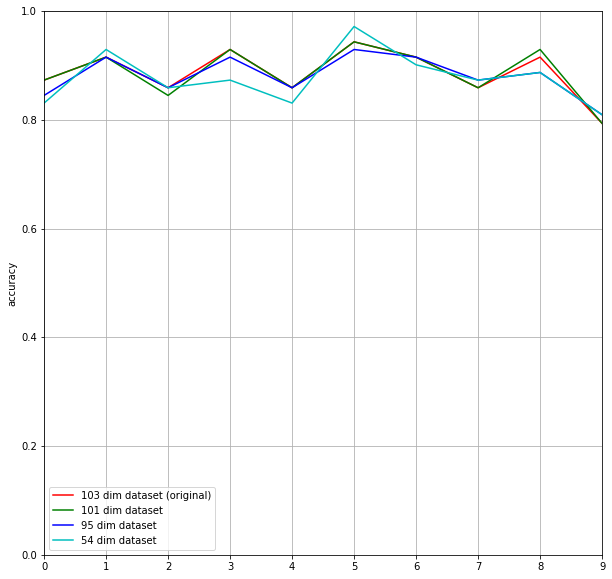

In [16]:
dataframes = [df_numeric, df_101, df_95, df_54]
r = eval_knn(dataframes, y, accuracy_score)
plt.figure(figsize=(10,10))
plt.ylabel('accuracy')
plt.axis([0, 9, 0, 1])
plt.grid(True)
plt.plot(r[0], color='r', label='103 dim dataset (original)')
plt.plot(r[1], color='g', label='101 dim dataset')
plt.plot(r[2], color='b', label='95 dim dataset')
plt.plot(r[3], color='c', label='54 dim dataset')
plt.legend(loc=0)
plt.show()

### Evaluación de Naive Bayes

In [17]:
def create_nb_classifier(target_attribute, X, y):
    
    attribute_info = {}
    attribute_list = []
    
    for c in X.columns.values:
        attribute_info[c] = DataSet.AttributeInfo(c, float)
        attribute_list.append(c)
    
    return NBClassifier(target_attribute, attribute_info, attribute_list)


def eval_nb(original_dataset, reduced_dataframes, y, metric_fn):

    r = [[] for _ in range(len(reduced_dataframes) + 1)]
    kf = KFold(n_splits=10, do_shuffle=False)
    indexes = kf.split(original_dataset.pandas_df)
    
    for test_indexes, training_indexes in indexes:
        
        clf = NBClassifier(target_attribute, ds.attribute_info, ds.attribute_list)
        
        y_test = y.iloc[test_indexes]
        X_test = ds.pandas_df.iloc[test_indexes]
        
        y_train = y.iloc[training_indexes]
        X_train = ds.pandas_df.iloc[training_indexes]
        
        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)
        r[0].append(metric_fn(y_test, y_predicted))
        
        for (i, X) in enumerate(reduced_dataframes):
            
            clf = create_nb_classifier(target_attribute, X, y)

            y_test = y.iloc[test_indexes]
            X_test = X.iloc[test_indexes]

            y_train = y.iloc[training_indexes]
            X_train = X.iloc[training_indexes]

            clf.fit(X_train, y_train)
            y_predicted = clf.predict(X_test)
            r[i+1].append(metric_fn(y_test, y_predicted))
        
        print('[' + '>'*len(r[0]) + ' '*(10-len(r[0])) + ']', end='\r')

    return r

#### Evaluación de accuracy

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


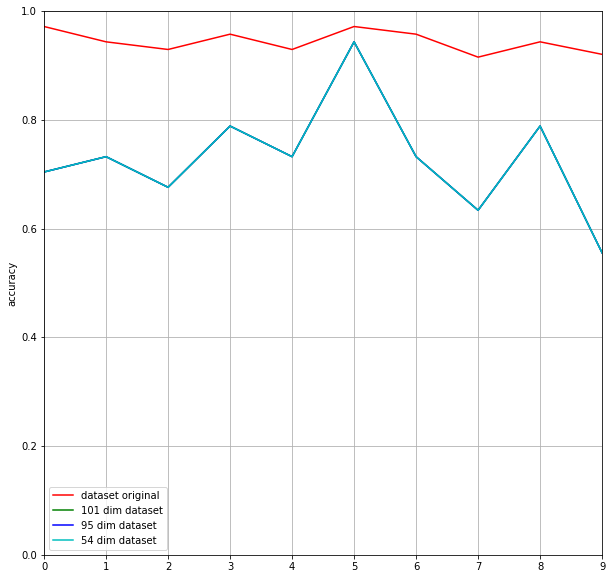

In [18]:
reduced_dataframes = [df_101, df_95, df_54]
original_dataset = ds
r = eval_nb(original_dataset, reduced_dataframes, y, accuracy_score)
plt.figure(figsize=(10,10))
plt.ylabel('accuracy')
plt.axis([0, 9, 0, 1])
plt.grid(True)
plt.plot(r[0], color='r', label='dataset original')
plt.plot(r[1], color='g', label='101 dim dataset')
plt.plot(r[1], color='b', label='95 dim dataset')
plt.plot(r[3], color='c', label='54 dim dataset')
plt.legend(loc=0)
plt.show()

## Referencias

[1] - <a id='referencia-1'></a> Scikit Learn, v0.19.0, chi2, [http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2]

[2] - <a id='referencia-2'></a> Scikit Learn, v0.19.1, Univariate feature selection, [http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection]
